In [1]:
from egnn_pytorch import EGNN_Network
import torch.nn as nn
import numpy as np
import random
import torch
from matplotlib import pyplot as plt
import glob
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict, OrderedDict
import dask.dataframe as dd
import math

#input:molecule/pdb from all_dat
#system = [solvents, data] 
#structure=pdb[]
elements = {
    "H": 1, "He": 2, "Li": 3, "Be": 4, "B": 5, "C": 6, "N": 7, "O": 8, "F": 9, "Ne": 10,
    "Na": 11, "Mg": 12, "Al": 13, "Si": 14, "P": 15, "S": 16, "Cl": 17, "Ar": 18, "K": 19,
    "Ca": 20, "Sc": 21, "Ti": 22, "V": 23, "Cr": 24, "Mn": 25, "Fe": 26, "Co": 27, "Ni": 28,
    "Cu": 29, "Zn": 30, "Ga": 31, "Ge": 32, "As": 33, "Se": 34, "Br": 35, "Kr": 36, "Rb": 37,
    "Sr": 38, "Y": 39, "Zr": 40, "Nb": 41, "Mo": 42, "Tc": 43, "Ru": 44, "Rh": 45, "Pd": 46,
    "Ag": 47, "Cd": 48, "In": 49, "Sn": 50, "Sb": 51, "I": 53, "Xe": 54, "Cs": 55, "Ba": 56,
    "La": 57, "Ce": 58, "Pr": 59, "Nd": 60, "Pm": 61, "Sm": 62, "Eu": 63, "Gd": 64, "Tb": 65,
    "Dy": 66, "Ho": 67, "Er": 68, "Tm": 69, "Yb": 70, "Lu": 71, "Hf": 72, "Ta": 73, "W": 74,
    "Re": 75, "Os": 76, "Ir": 77, "Pt": 78, "Au": 79, "Hg": 80, "Tl": 81, "Pb": 82, "Bi": 83,
    "Po": 84, "At": 85, "Rn": 86, "Fr": 87, "Ra": 88, "Ac": 89, "Th": 90, "Pa": 91, "U": 92,
    "Np": 93, "Pu": 94, "Am": 95, "Cm": 96, "Bk": 97, "Cf": 98, "Es": 99, "Fm": 100, "Md": 101,
    "No": 102, "Lr": 103, "Rf": 104, "Db": 105, "Sg": 106, "Bh": 107, "Hs": 108, "Mt": 109,
    "Ds": 110, "Rg": 111, "Cn": 112, "Nh": 113, "Fl": 114, "Mc": 115, "Lv": 116, "Ts": 117,
    "Og": 118
}

anions = {"HIS":("ND1", "ND2"),
                "ASP":("OD1","OD2"),
                "LYS":("NZ"),
                "TYR":("OH"),
                "GLU":("OE1", "OE2"),
                "CYS":("SG"),
                "ARG": ("NE1","NE2"),
                "THR":"OG1",
                "SER":"OG",
                "TRP":"NE1"}

class prepper():
    """This class aims to aggregate all of the information needed to generate an input into my model, 
    as well as a option to gather information needed  to train the model, and any additional components 
    needed for further training, including potential optional information for validating or developing.
    
    Ideally, this will include an option to download on the fly like pypka and other modern technology 
    provides. 
    
    My decisions made here are based off efficiency, bearing in mind flexibility to operating systems 
    ranging from openSUSE to macOS. Thus I aim to minimize bash scripts, at least for this class,
    which shall constitute my data prep (that being, all data used as present and future inputs,
    to train, validate, and analyze the model)
    
    This script shall rely on parsing a pdb, potentially biopython for neighborhood generation, and
    """
    def __init__(self, directory):
        self.directory = directory

    def load_pdb(self, path):
        """loads everything"""
        
        solvents, counter = {}, 0
        with open(path, "r") as f:
            resis, xs, counter = {}, [], 0
            for line in f:
                L = line.split()
                if line.startswith("ATOM"):
                    resname, atomname = L[3], L[2]
                    resname = resname + str(L[5]) + L[4]

                    if resname in resis:
                        resis[resname][f"{atomname} {counter}"] = (float(L[6]), float(L[7]), float(L[8]))
                        counter += 1

                    else:
                        resis[resname] = {f"{atomname} {counter}": (float(L[6]), float(L[7]), float(L[8]))}
                        counter += 1


                elif line.startswith("HETATM"):
                    resname = L[3] + str(L[5])
                    atomname = L[2]
                    if resname in solvents:
                        solvents[resname][f"{atomname} {str(counter)}"] = (float(L[6]), float(L[7]), float(L[8]))
                        counter += 1
                    else:
                        solvents[resname] = {f"{atomname} {str(counter)}": (float(L[6]), float(L[7]), float(L[8]))}
                    counter += 1
                    
    
        return resis, solvents

    def get_pdbs_list(self):
        """get the list of pdbs from the dictionary keys of "data".
        inputs: path to directory where input structures are saved"""
        directory=self.directory
        pdbids, data =[],{}
        solvents={}
        for file in glob.glob(directory + "/PDB/*red.pdb"):
            pdbid = file[-12:-8]
            data[pdbid], solvents[pdbid] = self.load_pdb(file)
            pdbids.append(pdbid)
        
        self.pdbs = pdbids
        self.residues, self.solvent = data, solvents
        return


        #return dd.read_csv(directory + "/pkas.csv", sep=';')

    
    from collections import OrderedDict
    def get_data(self):
        """returns dictionary of data with pdbids as keys and residueid indexed positions, atomic node and species information, input features (hydrogen indices), and the number of atoms in each sample (residue).
        all_species: {199l: {ASP1A : {CA:1} , ..., {TYR100 : {OXT:1032} } """
        
        all_pos, all_species, all_lengths = {},{},{}
        counter=0
        data,sdata = self.residues, self.solvent

        for pdb in self.pdbs:
            resis,solvents = data[pdb],sdata[pdb]
        #####residues##########
            lengths, species, R ={}, {}, OrderedDict()
            for resid, vals in resis.items(): 
                counter, resi_pos, resi_species = 0,{},{}
                for atom, pos in vals.items():
                    node = atom.split() 
                    atomname =node[0] 
                    resi_pos[counter] = pos
                    resi_species[atomname] = counter
                    counter +=1
                species[resid] = resi_species 
                R[resid] = resi_pos
                lengths[resid] = counter
            all_pos[pdb]= R
            all_species[pdb] = species
            all_lengths[pdb] = lengths
        #dicts = (all_ions, all_feats, all_pos, all_lengths, {k: v for k, v in all_targets.items() if not k.startswith('N') or k.startswith("CT")})
        dicts = (all_species, all_pos, all_lengths)
        all_rdata = defaultdict(dict)
        for title, d in zip(["Z", "R", "L"], dicts):
            for key, value in d.items():
                all_rdata[key][title] = value
        #####solvents########
            lengths, species, R ={}, {}, {}
            for resid, vals in solvents.items(): #solvents
                counter, resi_pos, resi_species = 0,{},{}
                for atom, pos in vals.items():
                    node = atom.split() 
                    atomname =node[0] 
                    resi_pos[counter] = pos
                    resi_species[atomname] = counter
                    counter +=1
                species[resid] = resi_species 
                R[resid] = resi_pos
                lengths[resid] = counter 
            all_pos[pdb]= R
            all_species[pdb] = species
            all_lengths[pdb] = lengths
        #dicts = (all_ions, all_feats, all_pos, all_lengths, {k: v for k, v in all_targets.items() if not k.startswith('N') or k.startswith("CT")})
        dicts = (all_species, all_pos, all_lengths)
        all_sdata = defaultdict(dict)
        for title, d in zip(["Z", "R", "L"], dicts):
            for key, value in d.items():
                all_sdata[key][title] = value

        self.residues,self.solvent = all_rdata, all_sdata

        return 



    def get_targets(self, calculate=False):
        """pdbs is the list which i have a data onject for"""
        all_targets={}
        pdbs, directory = self.pdbs, self.directory
        df = dd.read_csv(directory + "/pkas.csv", sep=';').compute()
        if calculate==True:
            for pdb in pdbs:
                targets={}
                d = df[df.iloc[:, 0] == pdb].drop(columns = ["idcode"]).to_dict(orient="records")
                for item in d:
                    num, resi, chain, pk = item['residue_number'], item['residue_name'], item["chain"], item["pk"]
                    targets[resi+str(num)+chain]= pk 
                all_targets[pdb] = targets

        self.targets = all_targets
        return df
        

    
    def get_Zs(self):
        """currently does for all resis."""
        rdata = self.residues
        sdata = self.solvent
        all_atomic_numbers = {}
        for pdb in self.pdbs:
            zs,szs={},{}
            #resis
            for res in list(rdata[pdb]["Z"].keys()):
                zs[res] = [torch.tensor(elements[a[0]]) for a in list((list(rdata[pdb]["Z"][res].keys())))]
            #solvents
            for res in list(sdata[pdb]["Z"].keys()):
                szs[res] = [torch.tensor(elements[a[0]]) for a in list((list(sdata[pdb]["Z"][res].keys())))]

            all_atomic_numbers[pdb] = zs
        self.atomic_numbers = all_atomic_numbers


            
            
    def run(self, get_labels=True):        
        self.get_pdbs_list()
        self.get_data()
        self.get_Zs()
        if get_labels==True:
            pkpdb = self.get_targets(calculate=True)
        else:
            pkpdb = self.get_targets(calculate=False)


        return self, pkpdb
        #return all_data,data, df, solvents, all_zs
#data,_,df,solvents,zs = prepper(directory = "/home/jrhoernschemeyer/Desktop/thesis/").run()


data, df =prepper(directory = "/home/jrhoernschemeyer/Desktop/thesis/").run()


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [143]:
data.residues.keys()

dict_keys(['10gs', '109l', '111m', '110m', '108m', '110l', '109m', '111l', '108l', '104m', '106m', '105m', '103m', '107m', '107l', '103l', '102m', '102l', '101m', '104l', '1'])

In [145]:
data.residues["10gs"].keys()

dict_keys(['Z', 'R', 'L'])

In [146]:
def EGNN1(num_nodes, depth):
    """This layer creates an embedding as well as hopefully navigates dimerrors produced by putting molecules with
    varying node size. 
    in
    feats = 1 x n_atoms

    input can be minimum one atom, this accomdates for rogue solo cofactors and unhydrogonated water."""
    net = EGNN_Network(
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=1,
        num_tokens=120,
        num_nearest_neighbors=1, 
        num_edge_tokens=1,
        global_linear_attn_every=1,
        global_linear_attn_dim_head=1,
        num_global_tokens=1,
        adj_dim=1,
        fourier_features=1,
        m_dim=1)
    return net
zs={}
def loop(data):
    """run model1
    
    later consider to put in the Hs after all, only for this first layerthen use updated pos"""
    #run model 1
    outs=OrderedDict()
    pdbs = data.pdbs
    #data=data.residues
    
    #Ds = {}
    all_zs={}
    for pdb in pdbs[:-1]:
        zs={}
        #print(pdb)
        out=OrderedDict()
        R, z = data.residues[pdb]["R"], data.atomic_numbers[pdb]

        for sample in z.keys():#len(feats)):
            feats=torch.tensor(z[sample])
            #print(feats)
            
            f=feats[feats != 1]
            coors=R[sample]
            
            pos = torch.tensor(list(coors.values())) #CHECKKKKK HERE FORRR MAJORRR POSSSSSIBLE ERRRROROROROR!! ACHTUNG)
            net = EGNN1(len(f),5)
            m=torch.tensor(3*[(np.array(torch.tensor(feats != 1)))])#.unsqueeze(0).shape
            c = pos[m.T].reshape(len(f),3,1).squeeze(2) #!!!!!!!!!!!!!!!!
            #c=pos
            #print(c.shape,f.shape)
            _ = net(f.unsqueeze(0),c.unsqueeze(0))
            out[sample] = _
            def dots(_):
                zs={}
                dots=[]
                for x in _[0]: #resi-species level resolution
                    z1=np.linalg.norm(np.sum(np.sum(np.gradient(np.gradient(x.detach().numpy())), axis=-1)[0],axis=-0))
                    #print(z1)
                    z2=np.linalg.norm(np.mean(np.mean(np.gradient(np.gradient(x.detach().numpy())), axis=-1)[0],axis=-0))
                    #print(z2)
                    
                    z3=(np.linalg.norm(np.mean(np.mean(np.gradient(np.gradient(x.detach().numpy())), axis=0)[0],axis=-0)))
                    #print(z3)
                    z=[z1,z2,z3]

                    #print(np.linalg.norm([z1,z2,z3])/np.max(z))
                    #print(sample, "done")
                    return np.linalg.norm([z1,z2,z3])
                    #r=norms[species]
                    #o =np.vstack([[z],[r]])
                    #dots.append(np.dot(o[0,:]-np.mean(o[0,:]),o[1,:]-np.mean(o[1,:])))
                #return zs #dots
            #dots(_)
            #zs[sample] = dots(_)
        outs[pdb] = out
        #all_zs[pdb] = zs
    return outs#, all_zs
    
    

all_outs = loop(data)
#plt.plot(all[outs])


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [241]:
sum([len(ks[0][0]) for ks in all_outs["10gs"].values()])

3276

get labels for the titratable residues

In [286]:

anions = {"HIS":("ND1", "ND2"),
        "ASP":("OD1","OD2"),
        "LYS":("NZ"),
        "TYR":("OH"),
        "GLU":("OE1", "OE2"),
        "CYS":("SG")}
import numpy as np
from sklearn.neighbors import NearestNeighbors

pdbs=data.pdbs
all_hoods=OrderedDict()
all_labels=OrderedDict()
prot=anions.keys()
for pdb in pdbs[:-1]:
    cs=[]
    ixs=[]
    labels=[]
    #if pdb == pdb:# "103l":
    print(pdb)
    #targets=[l for l in data.targets["10gs"].keys() if l[:2] not in ["NT","CT"]]
    targets=data.targets[pdb]
    
    d=all_outs[pdb]
    for sample in d.keys():
        try:
        #print(sample)
            if sample[:3] in prot:
                labels.append(targets[sample])
                
                cs.append(d[sample][1])
                #print(d[sample][1][0])
                #print(d[sample][1])
                


                ixs.append(d[sample][1][0][-1]) #gets tirtatable
                #labels.append(targets[sample])
                #cs.append()
        except:
            #print("except",pdb, sample)
            try:
                if sample[:3] in prot:
                    labels.append(targets[sample[:3] + str(int(sample[3:-1]) - 1) + sample[-1] ])
                    cs.append(d[sample][1]) #coords of the sample
                    ixs.append(d[sample][1][0][-1]) #side chain coordinate
            
            except:
                print("second except")
                print(sample)
                continue

            
            

        #print("sample")
#g#et_spheres(all_outs[])
    all_labels[pdb] = labels
    r=torch.cat(cs,dim=1)

    #ixs=torch.tensor([i.detach().numpy() for i in ixs])
    # Step 1: Define all_coords (coordinates of all atoms in the protein)

    all_coords = r[0].detach().numpy()
    # Step 3: Set a cutoff radius for neighborhood search (e.g., 3.0 Å)
    cutoff_radius = 4

    # Step 4: Initialize NearestNeighbors and fit it with all_coords (protein atoms)
    nbrs = NearestNeighbors(radius=cutoff_radius).fit(all_coords)

    # Step 5: Find neighbors within the cutoff radius for the N-terminal and C-terminal atoms
    _, indices = nbrs.radius_neighbors(torch.tensor([i.detach().numpy() for i in ixs]))
    hoodies=OrderedDict()
    #print(hoodies)
    # Step 6: Print the neighbors for each query atom
    for i, idx in enumerate(indices):

        #print(f"Neighbors for atom {i} (query point {ixs[i]}):")
        ns=[]
        #print(hoods)
        hoods = OrderedDict({i : all_coords[i]})
        #print(hoods)
        for neighbor_idx in idx:
            hoods[neighbor_idx] = all_coords[neighbor_idx]
        
        #print(hoodies)
        hoodies[i] = hoods#np.vstack(hoods) #np.concatenate(hoods,axis=0)
        #print(hoodies)
            #print(f"  Neighbor atom at index {neighbor_idx}: {all_coords[neighbor_idx]}")
    
    #np.shape(np.array(list(hoodies.values())))

    all_hoods[pdb] = hoodies

10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
second except
LYS35A
second except
ASP43CA
second except
LYS46A
second except
GLU48A
second except
ASP50A
second except
LYS51A
second except
LYS63A
second except
ASP64A
second except
GLU67A
second except
LYS68A
second except
ASP75A
second except
LYS88A
second except
TYR91A
second except
ASP95A
second except
GLU111A
second except
LYS127A
second except
ASP130A
second except
GLU131A
second except
LYS138A
second except
TYR142A
second except
LYS150A
second except
ASP162A
second except
TYR164A
second except
LYS165A
102m
102l
101m


In [275]:
[len(hoodie) for hoodie in hoodies.values()]

[7,
 9,
 7,
 5,
 8,
 8,
 10,
 6,
 8,
 8,
 7,
 6,
 8,
 7,
 6,
 7,
 5,
 9,
 6,
 6,
 8,
 6,
 7,
 6,
 7,
 8,
 10,
 8,
 7,
 10,
 12,
 8,
 5,
 7,
 5,
 7,
 6,
 5,
 9,
 6,
 6,
 7,
 7,
 10,
 6,
 8,
 6,
 7,
 9,
 9,
 10,
 5,
 6,
 9]

In [ ]:
df[df.iloc[:,0] =="103l"].sort_values("residue_number")

feats from layer 1 

In [287]:
from collections import OrderedDict
#all=OrderedDict()
all_nodes=OrderedDict()
all_titratable=OrderedDict()
for pdb in all_outs.keys():
    print(pdb)
    dd=all_outs[pdb]
    #dd=out
    titratable=OrderedDict()
    counter=0
    for resi in dd.keys():
        if resi[:3] in prot:
            titratable[counter] = dd[resi][0] #feats
            
            counter+=1
    
    all_titratable[pdb] = dd

    #pdbnodes=OrderedDict()
    #print(counter)
    counter=0
    nodes=OrderedDict()
    for t in titratable.values():# in range(len(titratable)): #for each set of features #for each tit resi
        
        #print(i)
        #d=titratable[i]
        #t = d[0]
        #print(t)
        
        for tt in t:#i in range(len((t.tolist()))): #for each resis features
            #print(tt)
            for ttt in tt: #for atom in features
                #print(ttt)
                #print(tt[0],"hi")
                #print(ttt,"hi")
                #print(counter)
                nodes[counter] = ttt
                #print(nodes)

                #print(tt)
            
                counter+=1
                #print(nodes)
                
    print(2)
    all_nodes[pdb]=nodes
    #print(counter)
    


    

10gs
2
109l
2
111m
2
110m
2
108m
2
110l
2
109m
2
111l
2
108l
2
104m
2
106m
2
105m
2
103m
2
107m
2
107l
2
103l
2
102m
2
102l
2
101m
2


In [288]:
len(all_nodes["10gs"])
[len(n) for n in all_nodes.values()] 

[980,
 360,
 501,
 501,
 501,
 351,
 501,
 351,
 351,
 509,
 501,
 509,
 491,
 501,
 351,
 359,
 491,
 351,
 501]

In [289]:
[len(n) for n in all_hoods.values()] 

[106, 39, 54, 54, 54, 38, 54, 38, 38, 55, 54, 55, 53, 54, 38, 15, 53, 38, 54]

In [290]:
all_nodes.keys()
#all_hoods.keys()
len(all_hoods)

19

In [292]:
[len(h) for h in all_hoods.values()]

[106, 39, 54, 54, 54, 38, 54, 38, 38, 55, 54, 55, 53, 54, 38, 15, 53, 38, 54]

In [293]:
counter3=0
hoodos=OrderedDict()
for pdb in all_hoods.keys():
    print(pdb)
    #if pdb != "109l":
        #for hs in all_hoods.values(): #all pdbs, pdbwise
    hoodfeats, hoodpos = {},{}
    hoodo=OrderedDict()
    counter2=0
    #(nodes[key],torch.tensor(hood[key])]
    hoodies=all_hoods[pdb]
    nodes=all_nodes[pdb]
    for hood in hoodies.values():
        #print(len(hood))
        
        counter=0
        for key in hood.keys():
            print(len(nodes))
            #afeat,pos = nodes[key],torch.tensor(hood[key])
            
            hoodfeats[counter]=nodes[key]
            #print(key)
            hoodpos[counter]=torch.tensor(hood[key])
            counter+=1
        hf, hpos = torch.vstack(list(hoodfeats.values())), torch.vstack(list(hoodpos.values()))
        hoodo[counter2] = (hf,hpos)
        
        counter2+=1
    
    hoodos[counter3]=hoodo 
    counter3+=1
        
    


    


10gs
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980

In [322]:
hoodos[2]

OrderedDict([(0,
              (tensor([[-1.1540,  1.6250,  2.8924],
                       [-0.4776,  0.4728,  0.5444],
                       [-2.5211, -1.2711,  0.1386],
                       [-1.6574, -0.6656,  1.3594],
                       [ 0.9862, -3.3218,  0.8972],
                       [ 2.8245, -2.0371,  0.4707],
                       [-1.4392, -0.3585,  0.9519]], grad_fn=<CatBackward0>),
               tensor([[ 32.1030,  18.5650, -13.2830],
                       [ 34.2550,  19.3680, -14.1700],
                       [ 35.6160,  19.9990, -13.8880],
                       [ 38.5940,  16.7100, -11.6340],
                       [ 36.3310,  17.8350, -13.1110],
                       [ 37.7100,  19.5020, -12.8260],
                       [ 36.6170,  19.0430, -13.2240]]))),
             (1,
              (tensor([[-0.8709, -0.7122,  1.7107],
                       [ 3.2389, -0.7114,  0.2541],
                       [-0.9113, -0.5591,  2.4486],
                       [-0.3036

In [44]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) *
                             (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_dim % 2 == 1:
            # Handle odd dimensions by filling the remaining column with cos()
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor with shape (seq_length, batch_size, embed_dim)
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class SimpleMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        """
        x: Tensor of shape (seq_length, batch_size, embed_dim)
        """
        # In self-attention, query, key, and value are all the same.
        attn_outputs, attn_weights = self.multihead_attn(x, x, x)
        return attn_outputs#, attn_weights


In [294]:
max([len(v[0]) for v in hoodo.values()])

12

In [304]:
[len(v[0]) for v in all_hoods.values()]

[7, 6, 7, 7, 9, 6, 8, 6, 6, 10, 7, 8, 8, 8, 6, 6, 8, 6, 7]

In [298]:
i=0
pdbss={}
for pdb in pdbs[:-1]:
    pdbss[i] =pdb
    i+=1

In [365]:
A = PositionalEncoding(22)
mha = SimpleMultiheadAttention(22,1)
#A = PositionalEncoding(3)
#mha = SimpleMultiheadAttention(3,1)
def EGNN2(num_nodes, depth):
    """This layer creates an embedding as well as hopefully navigates dimerrors produced by putting molecules with
    varying node size. 
    in
    feats = 1 x n_atoms

    input can be minimum one atom, this accomdates for rogue solo cofactors and unhydrogonated water."""
    net = EGNN_Network(
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=3,
        num_nearest_neighbors=2, 
        num_edge_tokens=2,
        global_linear_attn_every=1,
        global_linear_attn_dim_head=6,
        num_global_tokens=2,
        adj_dim=3,
        fourier_features=5,
        m_dim=10,
        dropout=0.3)
    
    return net
n=EGNN2(15, 1)
lin=nn.Linear(22,1)
#optimizer2 = torch.optim.Adam(list(lin.parameters()), lr=.001, weight_decay=0.001)
optimizer2 = torch.optim.Adam(list(n.parameters()) + list(mha.parameters()) + list(lin.parameters()), lr=.001, weight_decay=0.001)
criterion = nn.HuberLoss()

losses=[]
preds=[]
Ts=[]
counter=0
for e in range(20):
    counter=0
    for pdb in pdbs[:-1]:
        print(pdb)
        hoodo=hoodos[counter]
        counter+=1
        labels=all_labels[pdb]
        #for e in range(10):
            #print("one epoch")
            #for hoodo in hoodos.values():
        outs = []
        labels=all_labels[pdb]
        
        for x in range(len(hoodo)):
            
                optimizer2.zero_grad()  # Reset gradients before each iteration
                #print(hoodo[x].values())
                h=hoodo[x]
                #print(h)
                
                #h = torch.tensor(list(hoodo[x].values()))
                #print(np.array(list(h.values())))

                o = n(torch.tensor(h[0].unsqueeze(0).detach()), torch.tensor(h[1].unsqueeze(0).detach()))  # Forward pass
                #print(o[0].shape)

                #print(torch.sum(torch.sum(o[0], axis=-1)))

                # Use index 'x' to match corresponding label
                T = torch.tensor(labels[x])  # Ensure correct label is used for this iteration
                #print(x,T)

                # Calculate loss
                
                #print(loss.item())
                #print(torch.mean(torch.mean(o[0], axis=-1)), T)
                #print(pred)
                #pred=torch.sum(torch.mean(o[0][0].unsqueeze(0),dim=0)) 
                pk3=(torch.sum(torch.sum(mha(A(o[0][0].unsqueeze(2))), dim=0),dim=0))
                #out=lin(pk3)
                out=lin(pk3)
                #print(pk3)
                #print(out)
                #pred= torch.sum(mha(torch.tanh(A(o[0]))),dim=0)
                #print(pk3.item(),"pred")
                #print(loss.item(), "loss")
                
                #Ts.append(T)
                #print("")
                #pred=torch.mean((torch.mean(o[0][0].unsqueeze(0),dim=-1)))
                loss = criterion(out, T)
                #print(loss)
                # Perform backward pass and optimization step
                if counter not in [0,9,15]:
                    loss.backward()  # Retain graph if necessary
                    optimizer2.step()
                else:
                    #print(round(out.item(),3), round(T.item(),3), round(loss.item(),3))
                    losses.append(loss.item())
                    preds.append(out.item())
                    Ts.append(T.item())
                    # Store outputs
                    #outs.append(o)

            


10gs


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:972: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
10gs
109l
111m
110m
108m
110l
109m
111l
108l
104m
106m


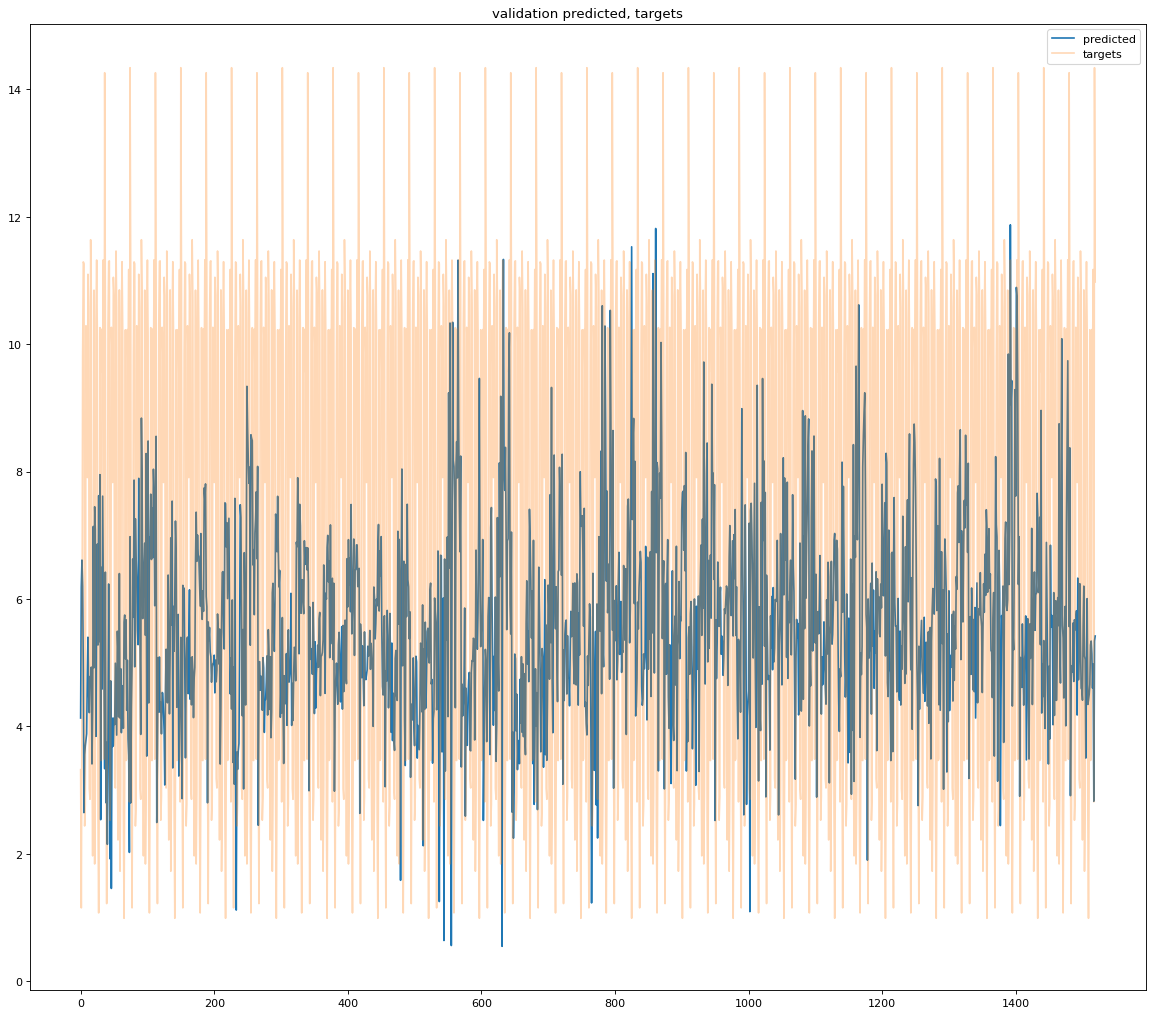

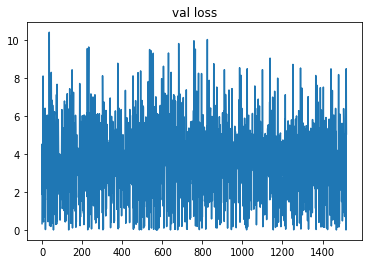

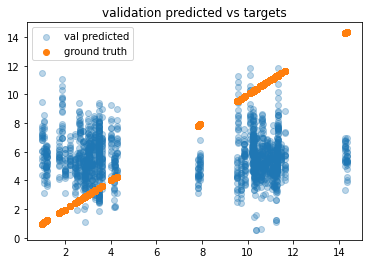

In [ ]:
plt.figure(figsize=(18, 16), dpi=80)
plt.plot(preds, label="predicted")
plt.plot(Ts,alpha=0.3,label="targets")
plt.legend()
plt.title("validation predicted, targets")
plt.show()
plt.plot(losses)
plt.title("val loss")
plt.show()
plt.scatter(Ts, preds,alpha=0.3, label="val predicted")
plt.scatter(Ts,Ts, label="ground truth")
plt.title("validation predicted vs targets")
plt.legend()
plt.show()

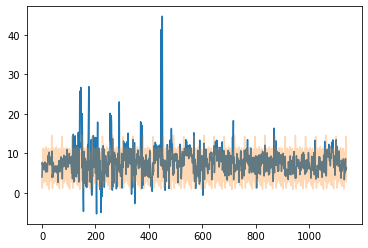

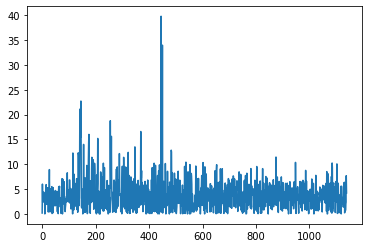

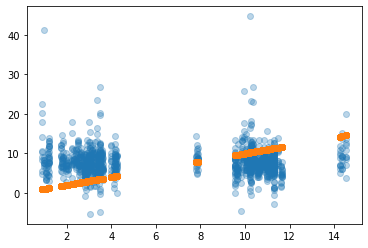

In [364]:
plt.plot(preds)
plt.plot(Ts,alpha=0.3)
plt.show()
plt.plot(losses)
plt.show()
plt.scatter(Ts, preds,alpha=0.3, label="val predicted")
plt.scatter(Ts,Ts, label="ground truth")
plt.show()

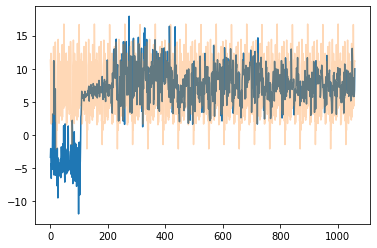

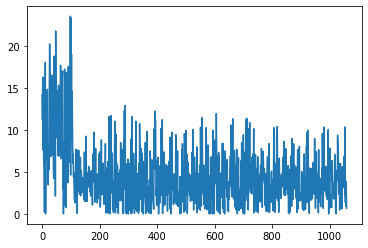

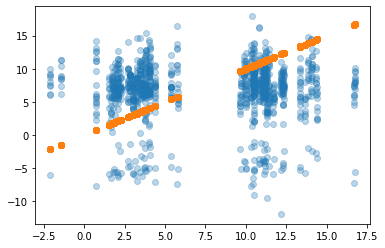

In [361]:
plt.plot(preds)
plt.plot(Ts,alpha=0.3)
plt.show()
plt.plot(losses)
plt.show()
plt.scatter(Ts, preds,alpha=0.3, label="val predicted")
plt.scatter(Ts,Ts, label="ground truth")
plt.show()

In [122]:
torch.sum(torch.mean(mha(A(o[0].unsqueeze(2))), dim=0))

ValueError: too many values to unpack (expected 3)

In [128]:
mha(A(o[0][0].unsqueeze(2)))

tensor([[[-0.4621, -1.0861, -0.3211,  ..., -0.2293,  0.3940,  0.8298],
         [-0.1596, -0.8372, -0.2981,  ..., -0.3108,  0.4864,  0.7040],
         [ 0.0644, -0.1928, -0.2332,  ..., -0.2230,  0.3111,  0.2927]],

        [[ 0.3196,  0.0821, -0.2081,  ..., -0.3523,  0.3469,  0.0416],
         [-0.0498, -0.6890, -0.3303,  ..., -0.3245,  0.4862,  0.6097],
         [ 0.3490,  0.2789, -0.1711,  ..., -0.2354,  0.3118, -0.0995]],

        [[-0.1551, -0.6533, -0.2870,  ..., -0.3163,  0.4038,  0.5924],
         [-0.5350, -2.9971, -1.4213,  ..., -0.7371,  0.8292,  2.8681],
         [-0.2290, -0.8266, -0.3791,  ..., -0.2008,  0.2978,  0.7831]],

        ...,

        [[-0.2341, -0.6835, -0.2968,  ..., -0.2557,  0.3812,  0.5810],
         [ 1.4406,  1.7167, -0.0586,  ..., -0.2029,  0.7640, -1.2289],
         [ 0.2409,  0.1521, -0.1470,  ..., -0.2877,  0.3432, -0.0081]],

        [[-0.8885, -2.0602, -0.5377,  ..., -0.0868,  0.5676,  1.4843],
         [ 0.0972, -0.3789, -0.2787,  ..., -0.2950,  0.

In [129]:
o[0][0]

tensor([[ 1.3210, -0.5358,  0.3265],
        [-1.3048, -0.9558,  1.2975],
        [ 0.5282, -2.5421,  0.7644],
        [-0.7293, -1.6016,  0.6005],
        [ 2.4529, -3.6589, -0.2900],
        [ 0.4060,  0.7776, -1.5817],
        [-1.1986, -0.3569, -0.7716],
        [-2.3768, -4.4619, -3.2354],
        [-1.0626, -3.1455,  1.5913],
        [-1.3609, -1.0716, -2.0760],
        [-2.0917, -1.0317, -0.1478],
        [ 0.9138, -0.9805,  0.3843],
        [-1.3962,  1.0510, -0.1749],
        [ 0.0075,  0.1331, -1.7010],
        [ 0.7122, -1.3414,  0.6090],
        [ 1.6106, -5.9182, -1.9021],
        [ 1.8546, -2.1526,  1.5139],
        [-0.3313, -0.5787, -1.1918],
        [ 2.2629, -2.4455,  2.3297],
        [-0.4274, -2.1527,  3.1038],
        [ 0.6876, -0.8395,  0.7936],
        [ 0.6733,  1.2578, -0.6172],
        [ 0.3099, -1.4164,  2.0906],
        [ 0.5529, -0.7123,  1.4592],
        [ 1.2423, -2.4044,  0.2180],
        [ 0.0683, -1.3035, -0.8941],
        [ 2.9689, -0.8437,  1.2448],
 

In [127]:
A=PositionalEncoding(100)
mha=SimpleMultiheadAttention(100,1)
A(o[0][0].unsqueeze(2))

tensor([[[ 1.4678,  2.5789,  1.4678,  ...,  2.5789,  1.4678,  2.5789],
         [-0.5953,  0.5158, -0.5953,  ...,  0.5158, -0.5953,  0.0000],
         [ 0.3627,  1.4738,  0.3627,  ...,  1.4738,  0.3627,  1.4738]],

        [[-0.0000, -0.8495, -0.6285,  ..., -0.3387, -1.4497, -0.3387],
         [-0.1271, -0.4617, -0.2408,  ...,  0.0491, -1.0619,  0.0491],
         [ 2.3767,  2.0420,  2.2630,  ...,  2.5528,  1.4418,  2.5528]],

        [[ 1.5972,  0.1245,  1.6932,  ...,  1.6980,  0.5872,  0.0000],
         [-1.8142, -3.2869, -1.7182,  ..., -1.7134, -2.8243, -0.0000],
         [ 1.8596,  0.3869,  1.9557,  ...,  0.0000,  0.8496,  1.9604]],

        ...,

        [[ 2.7917,  2.4030,  0.7470,  ...,  2.9471,  1.8480,  2.9471],
         [-1.2882, -1.6770, -3.3329,  ..., -1.1328, -2.2320, -1.1328],
         [ 2.1254,  1.7366,  0.0807,  ...,  2.2808,  1.1816,  2.2808]],

        [[ 4.7868,  3.2956,  3.2227,  ...,  4.9045,  3.8055,  4.9045],
         [ 0.0801, -1.4111, -1.4840,  ...,  0.1978, -0.

In [117]:
o[0][0]

tensor([[ 9.4401e-01,  7.9826e-01, -1.4659e+00],
        [-2.4397e+00, -3.4553e-02,  4.9146e-01],
        [-1.0776e-01, -3.1269e+00,  3.9301e-01],
        [ 9.7094e-01, -5.8927e-01,  2.6472e-01],
        [ 2.2200e-01, -3.1148e+00, -1.1409e+00],
        [-7.0607e-01, -1.1998e+00, -2.8139e+00],
        [-2.0779e-01,  2.5149e+00,  1.2261e+00],
        [-3.4939e-01, -3.4231e+00, -2.6629e+00],
        [ 2.4023e+00, -3.4970e+00, -4.9505e-01],
        [-1.6374e+00, -2.1268e+00, -1.8137e+00],
        [-1.6547e-01,  1.7098e+00,  2.2414e+00],
        [-1.6737e+00,  1.2229e+00, -7.1298e-01],
        [-8.1847e-01,  1.0637e+00,  2.2324e+00],
        [ 1.0541e+00,  1.4622e+00,  1.4589e-01],
        [ 1.6938e-01,  1.7242e+00, -1.4066e+00],
        [ 1.2007e+00, -2.5628e+00, -2.3305e+00],
        [ 1.4667e-02, -1.1182e+00,  1.4586e+00],
        [ 1.0888e+00,  2.1238e+00, -4.5735e-01],
        [ 1.1623e+00, -1.0596e+00,  1.7883e+00],
        [ 7.9609e-01, -9.1980e-01,  9.4934e-01],
        [ 1.9145e+00

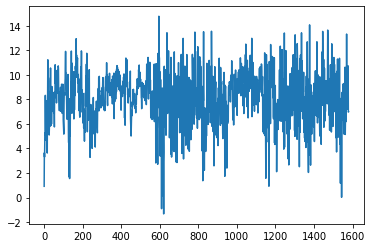

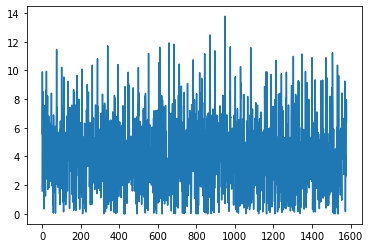

In [140]:
plt.plot(preds)
plt.show()
plt.plot(losses)

In [ ]:
preds

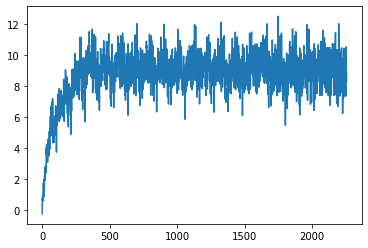

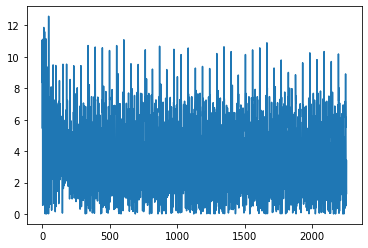

In [138]:
plt.plot(preds)
plt.show()
plt.plot(losses)

In [111]:
type(outs)

list

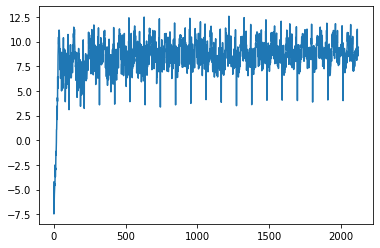

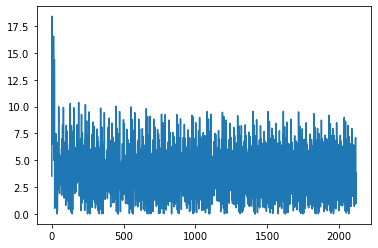

In [102]:
plt.plot(preds)
plt.show()
plt.plot(losses)

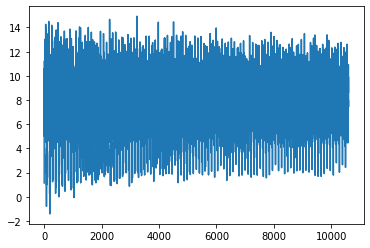

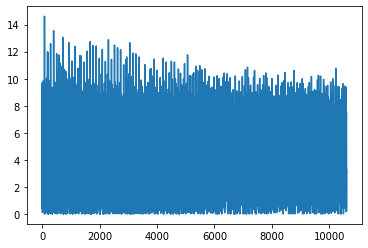

In [106]:
plt.plot(preds)
plt.show()
plt.plot(losses)

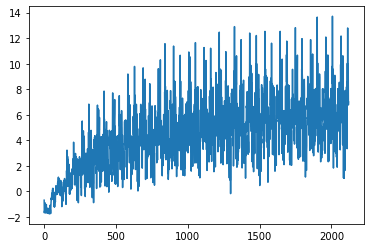

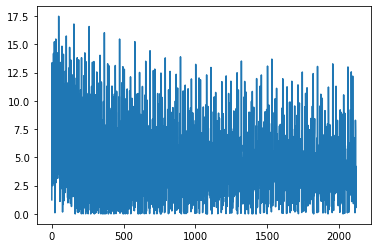

In [104]:
plt.plot(preds)
plt.show()
plt.plot(losses)

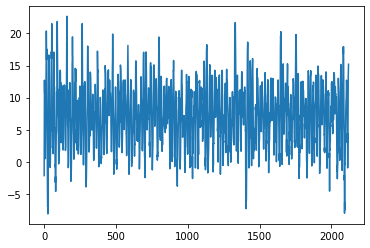

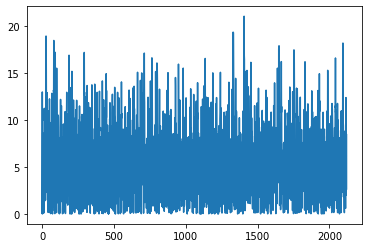

In [99]:
plt.plot(preds)
plt.show()
plt.plot(losses)

In [65]:
sum(Ts[:106])/106

tensor(7.5440)

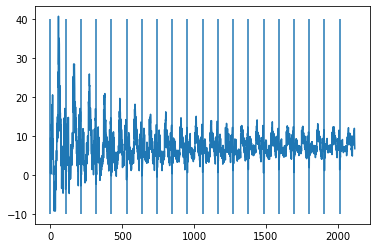

In [90]:
plt.plot(preds)
for i in range(20):
    plt.vlines(106*i,-10,40)

In [356]:
torch.mean((torch.mean(o[0][0].unsqueeze(0),dim=-1)))
#torch.mean(torch.sum(mha(A(o[0])),dim=0))

tensor(8.7355, grad_fn=<MeanBackward0>)

In [350]:
torch.sum(torch.sum(mha(A(outs[0][0])),dim=0).detach().numpy())

IndexError: list index out of range

In [339]:
#torch.mean(torch.sum(outs[0][0][0].unsqueeze(0),dim=0)) +   
np.mean(torch.sum(mha(A(outs[0][0])),dim=0))

IndexError: list index out of range

In [217]:
max([len(v[0]) for v in hoodo.values()])

13

In [224]:
torch.sum(outs[1][0],dim=-1)

tensor([[26.4635, 30.1888, 30.9564, 32.1489, 29.5027, 28.0026, 27.1678]],
       grad_fn=<SumBackward1>)

In [ ]:
torch.sum(outs[i][0][0],dim=-1)

In [234]:
labels[0:20]

[11.3108,
 9.66513,
 12.3283,
 1.6541299999999999,
 11.1225,
 1.8763900000000002,
 3.491,
 4.053640000000001,
 3.83331,
 10.5261,
 10.7954,
 13.3563,
 11.4235,
 3.12194,
 3.76229,
 9.93648,
 5.37399,
 14.0334,
 11.7278,
 2.10677]

AttributeError: module 'torch' has no attribute 'outs'

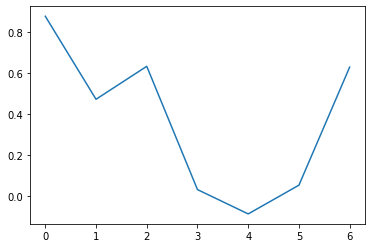

In [368]:
zs=[]
for i in range(20):
    plt.plot(((torch.sum(outs[i][0][0],dim=-1))).detach().numpy())
    zs.append(((torch.outs(outs[i][0][0],dim=-1))).detach().numpy())
    plt.show()
#plt.plot(outs[0][0].detach().numpy())
#plt.plot(zs)

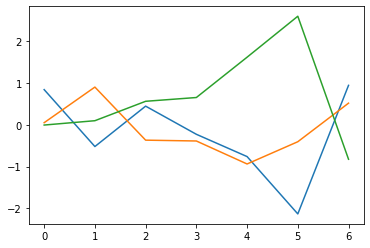

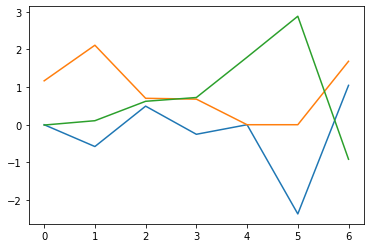

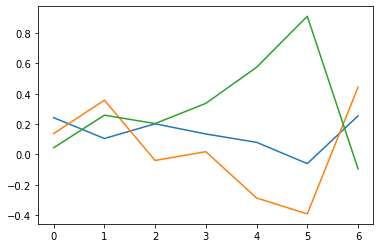

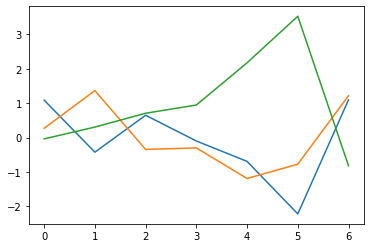

In [369]:
plt.plot(torch.sum((outs[0][0][0].unsqueeze(0)),dim=0).detach().numpy())
plt.show()
plt.plot(torch.sum(A(outs[0][0]),dim=0).detach().numpy())
plt.show()
plt.plot(torch.sum(mha(outs[0][0][0].unsqueeze(0)),dim=0).detach().numpy())
plt.show()
plt.plot(torch.sum(outs[0][0][0].unsqueeze(0),dim=0).detach().numpy() + (torch.sum(mha(A(outs[0][0])),dim=0).detach().numpy()))

In [335]:
np.mean(torch.sum(outs[0][0][0].unsqueeze(0),dim=0).detach().numpy() +  np.sum((torch.sum(mha(A(outs[0][0])),dim=0).detach().numpy())))

11.810826

In [317]:
labels

[11.3108,
 9.66513,
 12.3283,
 1.6541299999999999,
 11.1225,
 1.8763900000000002,
 3.491,
 4.053640000000001,
 3.83331,
 10.5261,
 10.7954,
 13.3563,
 11.4235,
 3.12194,
 3.76229,
 9.93648,
 5.37399,
 14.0334,
 11.7278,
 2.10677,
 2.99493,
 -2.08976,
 2.04279,
 0.720119,
 3.7668800000000005,
 10.5065,
 11.2875,
 14.4342,
 10.0359,
 10.8418,
 1.77688,
 12.3084,
 3.5621,
 3.24708,
 11.1035,
 11.0595,
 10.463,
 2.8519799999999997,
 10.3472,
 3.68194,
 2.24571,
 13.6518,
 2.7138299999999997,
 5.78009,
 4.02044,
 12.177999999999999,
 4.0267800000000005,
 16.7491,
 10.5335,
 10.5017,
 4.41164,
 11.2606,
 11.1899,
 11.3018,
 9.698139999999999,
 12.367,
 1.54906,
 11.1642,
 1.9062700000000001,
 3.4797599999999997,
 4.033440000000001,
 3.8428,
 10.3911,
 10.8956,
 13.3665,
 11.4268,
 3.14929,
 3.75998,
 10.0447,
 5.376519999999999,
 14.1107,
 11.6971,
 2.10338,
 3.0055,
 -1.4355200000000001,
 2.08924,
 0.709659,
 3.46987,
 10.4488,
 11.1985,
 14.3269,
 9.863719999999999,
 10.9655,
 1.7390599999

In [295]:
mha(A(outs[0][0]))

tensor([[[ 0.5580, -0.9106,  0.4245],
         [ 0.3514, -0.2667,  0.4139],
         [ 0.4432, -0.7012,  0.6384],
         [ 0.1492,  0.9398, -0.2048],
         [ 0.2987, -0.1877,  0.4478],
         [ 1.1743, -4.6338,  2.2548],
         [ 0.4239, -1.3249,  1.1783]]], grad_fn=<AddBackward0>)

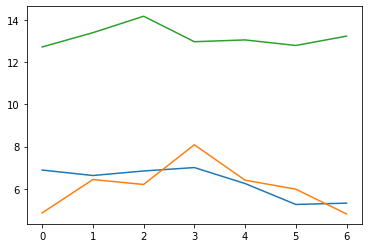

In [282]:
mha(outs[0][0][0].unsqueeze(0))
plt.plot(torch.mean((outs[0][0][0].unsqueeze(0)),dim=0).detach().numpy())

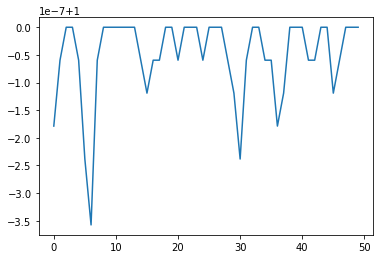

In [242]:
plt.plot(np.concatenate(zs)[0:50])

In [ ]:
def EGNN2(num_nodes, depth):
    """This layer creates an embedding as well as hopefully navigates dimerrors produced by putting molecules with
    varying node size. 
    in
    feats = 1 x n_atoms

    input can be minimum one atom, this accomdates for rogue solo cofactors and unhydrogonated water."""
    net = EGNN_Network(
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=10,
        num_nearest_neighbors=2, 
        num_edge_tokens=1,
        global_linear_attn_every=1,
        global_linear_attn_dim_head=1,
        num_global_tokens=1,
        adj_dim=1,
        fourier_features=1,
        m_dim=1)
    
    return net
n=EGNN2(max([len(v[0]) for v in hoodo.values()]),1)
optimizer = torch.optim.Adam(n.parameters(), lr=.001, weight_decay=.001)
criterion = nn.HuberLoss()
outs=[]


for x in range(len(hoodo)):
    optimizer.zero_grad()
    counter=0
    h=hoodo[x]
    o=n(h[0].unsqueeze(0),h[1].unsqueeze(0))#hoodo[0][1])
    print(torch.sum(torch.sum(o[0],axis=-1)))
    T=torch.tensor(labels[counter])
    loss = criterion((torch.sum(torch.sum(o[0],axis=-1))), T)
    counter+=1
    loss.backward()
    optimizer.step()
    outs.append(o)

    def plot(outs,hoodo,x):
        plt.plot(torch.sum(hoodo[x][0],axis=-1).detach().numpy())
        plt.plot(torch.sum(outs[x][0][0],axis=-1).detach().numpy())
        plt.show()
        plt.plot(torch.sum(hoodo[x][1],axis=-1).detach().numpy())
        plt.plot(torch.sum(outs[x][1][0],axis=-1).detach().numpy())
        plt.show()
    
    plot(outs,hoodo,x)

    if x==1:
        break

tensor(-390.2433, grad_fn=<SumBackward0>)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [128]:
(torch.sum(torch.sum(outs[1][0],axis=-1)))

tensor(35.8103, grad_fn=<SumBackward0>)

In [138]:
data.targets["10gs"].keys()

dict_keys(['TYR79B', 'GLU30A', 'CYS14B', 'ASP116A', 'ASP146B', 'LYS140A', 'CYS101B', 'CTR209A', 'TYR198B', 'ASP82B', 'ASP57B', 'ASP59B', 'LYS188A', 'TYR103A', 'GLU31B', 'TYR7A', 'LYS115A', 'LYS81B', 'LYS127A', 'LYS102A', 'LYS120A', 'GLU197B', 'GLU36A', 'GLU97A', 'TYR118A', 'ASP90B', 'TYR49A', 'ASP117A', 'TYR3B', 'TYR153B', 'TYR111B', 'CYS47A', 'LYS188B', 'TYR49B', 'ASP171B', 'GLU130B', 'GLU112A', 'TYR63B', 'CYS47B', 'TYR3A', 'TYR111A', 'GLU85A', 'LYS190B', 'ASP146A', 'ASP98A', 'ASP94B', 'HIS71B', 'LYS190A', 'GLU97B', 'TYR79A', 'CTR209B', 'GLU40B', 'GLU85B', 'GLU112B', 'LYS140B', 'ASP157B', 'ASP23A', 'LYS54A', 'LYS54B', 'LYS208B', 'ASP117B', 'LYS44A', 'ASP116B', 'CYS169A', 'ASP23B', 'TYR103B', 'ASP152A', 'LYS102B', 'LYS127B', 'HIS162B', 'TYR198A', 'TYR153A', 'GLU30B', 'GLU197A', 'LYS29B', 'ASP59A', 'ASP90A', 'ASP94A', 'LYS115B', 'GLU163A', 'TYR108B', 'GLU130A', 'CYS101A', 'LYS44B', 'HIS71A', 'LYS120B', 'ASP57A', 'TYR7B', 'HIS162A', 'CYS169B', 'ASP98B', 'TYR63A', 'TYR118B', 'ASP152B', 'T

In [137]:
len([l for l in data.targets["10gs"].keys() if l[:2] not in ["NT","CT"]])
len(hoodo)

106

In [403]:

zs={}
def loop(data):
    """run model1
    
    later consider to put in the Hs after all, only for this first layerthen use updated pos"""
    #run model 1
    outs={}
    pdbs = data.pdbs
    #data=data.residues
    
    #Ds = {}
    all_zs={}
    #for pdb in pdbs[:1]:
    for hood in hoodies.values():
        zs={}
        print(pdb)
        out={}
        #d = data.residues[pdb]
        #R, z = data.residues[pdb]["R"], data.atomic_numbers[pdb]

        data=all_outs[pdb]
        #R, z = data[1], data[0]
        for sample in data.keys():#len(feats)):
            d=data[sample]
            feats, coors = d[0],d[1]
            #feats=torch.tensor(z[sample])
            #print(feats)
            
            f=feats #[feats != 1]
            #coors=R[sample]
            #print(f.shape, coors.shape)
            #pos = torch.tensor(list(coors.values())) #CHECKKKKK HERE FORRR MAJORRR POSSSSSIBLE ERRRROROROROR!! ACHTUNG)
            net = EGNN2(f.shape[1],5)
            #m=torch.tensor(3*[(np.array(torch.tensor(feats != 1)))])#.unsqueeze(0).shape
            #c = pos[m.T].reshape(len(f),3,1).squeeze(2) #!!!!!!!!!!!!!!!!
            #print(f,c)
            #out=net(f.unsqueeze(0),c.unsqueeze(0))

    #x, _ = model(feats.unsqueeze(0), pos.unsqueeze(0)) #can turn off return po
            _ = net(f,coors)
            if sample in anions.keys():
                out[sample] = _
                def dots(_):
                    zs={}
                    dots=[]
                    for x in _[0]: #resi-species level resolution
                        z1=np.linalg.norm(np.sum(np.sum(np.gradient(np.gradient(x.detach().numpy())), axis=-1)[0],axis=-0))
                        #print(z1)
                        z2=np.linalg.norm(np.mean(np.mean(np.gradient(np.gradient(x.detach().numpy())), axis=-1)[0],axis=-0))
                        #print(z2)
                        
                        z3=(np.linalg.norm(np.mean(np.mean(np.gradient(np.gradient(x.detach().numpy())), axis=0)[0],axis=-0)))
                        #print(z3)
                        z=[z1,z2,z3]

                        #print(np.linalg.norm([z1,z2,z3])/np.max(z))
                        #print(sample, "done")
                        return np.linalg.norm([z1,z2,z3])
                        #r=norms[species]
                        #o =np.vstack([[z],[r]])
                        #dots.append(np.dot(o[0,:]-np.mean(o[0,:]),o[1,:]-np.mean(o[1,:])))
                    #return zs #dots
                #dots(_)
                #zs[sample] = dots(_)
            outs[pdb] = out
            all_zs[pdb] = zs
        return outs, all_zs
    
    

all_outs,zs = loop(data)
#z=[0,0]
z=list(list(zs.values())[0].values())
#print(sum(z))
#plt.plot(list(list(zs.values())[0].values()),"o")

10gs


IndexError: list index out of range

tensor([ 0.6861, -0.7154, -1.8409], grad_fn=<UnbindBackward0>)
2
tensor([ 1.3500, -0.0765,  2.6280], grad_fn=<UnbindBackward0>)
2
tensor([ 0.5849, -0.9533,  1.3376], grad_fn=<UnbindBackward0>)
2
tensor([-0.2330,  1.9742, -1.4493], grad_fn=<UnbindBackward0>)
2
tensor([ 0.8213, -0.2942,  1.0189], grad_fn=<UnbindBackward0>)
2
tensor([0.2847, 1.9975, 0.8734], grad_fn=<UnbindBackward0>)
2
tensor([2.0443, 0.2167, 0.6753], grad_fn=<UnbindBackward0>)
2
tensor([ 2.5003, -1.3984,  0.3585], grad_fn=<UnbindBackward0>)
2
tensor([ 2.6804, -1.5228,  1.0111], grad_fn=<UnbindBackward0>)
2
tensor([ 0.6115,  0.2416, -0.3259], grad_fn=<UnbindBackward0>)
2
tensor([ 0.9407, -1.0106,  1.2371], grad_fn=<UnbindBackward0>)
2
tensor([-0.6567,  1.1539, -0.3686], grad_fn=<UnbindBackward0>)
2
tensor([ 2.5083,  0.3798, -1.3124], grad_fn=<UnbindBackward0>)
2
tensor([-2.5111,  0.3668, -0.7545], grad_fn=<UnbindBackward0>)
2
tensor([-2.3936,  1.1919,  2.6561], grad_fn=<UnbindBackward0>)
2
tensor([-0.3697,  2.8555, -0.01

1458

In [574]:
nodes[1]

tensor([ 0.7478, -1.5098,  2.0140], grad_fn=<UnbindBackward0>)

In [597]:
n=EGNN2(150,1)
nodefeats={}
nodecoords={}
allhoods={}
for key in hoodies.keys():
#hoodcoords, hoodfeats=[],[]
    for hnode in hoodies[key]:
        print(hnode)


        #for anode in hnode:
            #print(anode)
            i=hnode
            nodefeats[i] = nodes[i] #nodes is features

            nodecoords[i] = hoodies[i]
            
            #print(coord)
            #print(hood)

        cs, fs=[],[]
    #for key in hoodies.keys():
        fs.append(nodefeats[key])
        cs.append(nodecoords[key])

        allhoods[key] = (fs,cs)#hoodcoords)
    pos, f =torch.tensor(cs),torch.vstack(fs)
print(pos.shape,f.shape)
#o=n(hoodfeats,hoodcoords)

    #print(o)
    #break
    #print(torch.tensor(nodecoords[key]))
    

IndentationError: unexpected indent (<ipython-input-597-0b3fd8bcf7ed>, line 13)

In [ ]:
len(allhoods[163][2])

IndexError: tuple index out of range

In [ ]:
torch.vstack([torch.tensor(h) for h in allhoods[1]]).shape

ValueError: only one element tensors can be converted to Python scalars

In [546]:
f, R = allhoods[2]
f = torch.vstack(f)
p=torch.vstack([torch.tensor(p) for p in R])
p
p.shape
f.shape

torch.Size([164, 3])

In [503]:
def EGNN2(num_nodes, depth):
    """This layer creates an embedding as well as hopefully navigates dimerrors produced by putting molecules with
    varying node size. 
    in
    feats = 1 x n_atoms

    input can be minimum one atom, this accomdates for rogue solo cofactors and unhydrogonated water."""
    net = EGNN_Network(
        num_positions = 1, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=1,
        num_nearest_neighbors=2, 
        num_edge_tokens=1,
        global_linear_attn_every=1,
        global_linear_attn_dim_head=1,
        num_global_tokens=1,
        adj_dim=1,
        fourier_features=1,
        m_dim=1)
    
    return net

for key in hoodies.keys():
    print(nodefeats[key])
    break

tensor([-1.2199, -1.8144, -1.1787], grad_fn=<UnbindBackward0>)


In [428]:
def EGNN2(num_nodes, depth):
    """This layer creates an embedding as well as hopefully navigates dimerrors produced by putting molecules with
    varying node size. 
    in
    feats = 1 x n_atoms

    input can be minimum one atom, this accomdates for rogue solo cofactors and unhydrogonated water."""
    net = EGNN_Network(
        num_positions = 100, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=1,
        num_nearest_neighbors=2, 
        num_edge_tokens=1,
        global_linear_attn_every=1,
        global_linear_attn_dim_head=1,
        num_global_tokens=1,
        adj_dim=1,
        fourier_features=1,
        m_dim=1)
    
    return net



zs={}
def loop(data):
    """run model1
    
    later consider to put in the Hs after all, only for this first layerthen use updated pos"""
    #run model 1
    outs={}
    pdbs = data.pdbs
    #data=data.residues
    
    #Ds = {}
    all_zs={}
    #for pdb in pdbs[:1]:
    for hood in hoodies.values():
        zs={}
        print(pdb)
        out={}
        #d = data.residues[pdb]
        #R, z = data.residues[pdb]["R"], data.atomic_numbers[pdb]

        data=torch.tensor(list(hood))#all_outs[pdb]
        print(hood.shape)
        #R, z = data[1], data[0]
        for i in range(hood.shape[0]):#len(feats)):
            #print(sample)
            d=data#[sample]
            coors=d
            #feats=torch.tensor(z[sample])
            #print(feats)
            
            f=feats #[feats != 1]
            #coors=R[sample]
            #print(f.shape, coors.shape)
            #pos = torch.tensor(list(coors.values())) #CHECKKKKK HERE FORRR MAJORRR POSSSSSIBLE ERRRROROROROR!! ACHTUNG)
            net = EGNN2(f.shape[1],5)
            #m=torch.tensor(3*[(np.array(torch.tensor(feats != 1)))])#.unsqueeze(0).shape
            #c = pos[m.T].reshape(len(f),3,1).squeeze(2) #!!!!!!!!!!!!!!!!
            #print(f,c)
            #out=net(f.unsqueeze(0),c.unsqueeze(0))

    #x, _ = model(feats.unsqueeze(0), pos.unsqueeze(0)) #can turn off return po
            _ = net(f,coors)
            out[sample] = _
            def dots(_):
                zs={}
                dots=[]
                for x in _[0]: #resi-species level resolution
                    z1=np.linalg.norm(np.sum(np.sum(np.gradient(np.gradient(x.detach().numpy())), axis=-1)[0],axis=-0))
                    #print(z1)
                    z2=np.linalg.norm(np.mean(np.mean(np.gradient(np.gradient(x.detach().numpy())), axis=-1)[0],axis=-0))
                    #print(z2)
                    
                    z3=(np.linalg.norm(np.mean(np.mean(np.gradient(np.gradient(x.detach().numpy())), axis=0)[0],axis=-0)))
                    #print(z3)
                    z=[z1,z2,z3]

                    #print(np.linalg.norm([z1,z2,z3])/np.max(z))
                    #print(sample, "done")
                    return np.linalg.norm([z1,z2,z3])
                    #r=norms[species]
                    #o =np.vstack([[z],[r]])
                    #dots.append(np.dot(o[0,:]-np.mean(o[0,:]),o[1,:]-np.mean(o[1,:])))
                #return zs #dots
            #dots(_)
            zs[sample] = dots(_)
        outs[pdb] = out
        all_zs[pdb] = zs
    return outs, all_zs
    
    

all_outs,zs = loop(data)
#z=[0,0]
z=list(list(zs.values())[0].values())
#print(sum(z))
#plt.plot(list(list(zs.values())[0].values()),"o")

10gs


AttributeError: 'dict' object has no attribute 'shape'

10gs
torch.Size([1, 7, 3]) torch.Size([1, 7, 3])
torch.Size([1, 7, 3]) torch.Size([1, 7, 3])
torch.Size([1, 12, 3]) torch.Size([1, 12, 3])
torch.Size([1, 7, 3]) torch.Size([1, 7, 3])
torch.Size([1, 7, 3]) torch.Size([1, 7, 3])
torch.Size([1, 7, 3]) torch.Size([1, 7, 3])
torch.Size([1, 12, 3]) torch.Size([1, 12, 3])
torch.Size([1, 11, 3]) torch.Size([1, 11, 3])
torch.Size([1, 7, 3]) torch.Size([1, 7, 3])
torch.Size([1, 7, 3]) torch.Size([1, 7, 3])
torch.Size([1, 11, 3]) torch.Size([1, 11, 3])
torch.Size([1, 4, 3]) torch.Size([1, 4, 3])
torch.Size([1, 11, 3]) torch.Size([1, 11, 3])
torch.Size([1, 6, 3]) torch.Size([1, 6, 3])
torch.Size([1, 5, 3]) torch.Size([1, 5, 3])
torch.Size([1, 5, 3]) torch.Size([1, 5, 3])
torch.Size([1, 8, 3]) torch.Size([1, 8, 3])
torch.Size([1, 11, 3]) torch.Size([1, 11, 3])
torch.Size([1, 8, 3]) torch.Size([1, 8, 3])
torch.Size([1, 8, 3]) torch.Size([1, 8, 3])
torch.Size([1, 8, 3]) torch.Size([1, 8, 3])
torch.Size([1, 5, 3]) torch.Size([1, 5, 3])
torch.Size([1, 

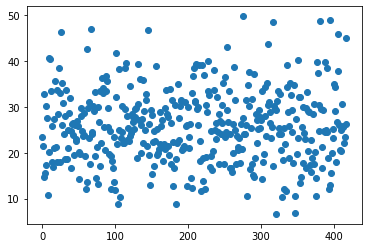

In [372]:
def EGNN2(num_nodes, depth):
    """This layer creates an embedding as well as hopefully navigates dimerrors produced by putting molecules with
    varying node size. 
    in
    feats = 1 x n_atoms

    input can be minimum one atom, this accomdates for rogue solo cofactors and unhydrogonated water."""
    net = EGNN_Network(
        num_positions = 100, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=1,
        num_nearest_neighbors=2, 
        num_edge_tokens=1,
        global_linear_attn_every=1,
        global_linear_attn_dim_head=1,
        num_global_tokens=1,
        adj_dim=1,
        fourier_features=1,
        m_dim=1)
    
    return net



zs={}
def loop(data):
    """run model1
    
    later consider to put in the Hs after all, only for this first layerthen use updated pos"""
    #run model 1
    outs={}
    pdbs = data.pdbs
    #data=data.residues
    
    #Ds = {}
    all_zs={}
    for pdb in pdbs[:1]:
        zs={}
        print(pdb)
        out={}
        #d = data.residues[pdb]
        #R, z = data.residues[pdb]["R"], data.atomic_numbers[pdb]

        data=all_outs[pdb]
        #R, z = data[1], data[0]
        for sample in data.keys():#len(feats)):
            d=data[sample]
            feats, coors = d[0],d[1]
            #feats=torch.tensor(z[sample])
            #print(feats)
            
            f=feats #[feats != 1]
            #coors=R[sample]
            print(f.shape, coors.shape)
            #pos = torch.tensor(list(coors.values())) #CHECKKKKK HERE FORRR MAJORRR POSSSSSIBLE ERRRROROROROR!! ACHTUNG)
            net = EGNN2(f.shape[1],5)
            #m=torch.tensor(3*[(np.array(torch.tensor(feats != 1)))])#.unsqueeze(0).shape
            #c = pos[m.T].reshape(len(f),3,1).squeeze(2) #!!!!!!!!!!!!!!!!
            #print(f,c)
            #out=net(f.unsqueeze(0),c.unsqueeze(0))

    #x, _ = model(feats.unsqueeze(0), pos.unsqueeze(0)) #can turn off return po
            _ = net(f,coors)
            out[sample] = _
            def dots(_):
                zs={}
                dots=[]
                for x in _[0]: #resi-species level resolution
                    z1=np.linalg.norm(np.sum(np.sum(np.gradient(np.gradient(x.detach().numpy())), axis=-1)[0],axis=-0))
                    #print(z1)
                    z2=np.linalg.norm(np.mean(np.mean(np.gradient(np.gradient(x.detach().numpy())), axis=-1)[0],axis=-0))
                    #print(z2)
                    
                    z3=(np.linalg.norm(np.mean(np.mean(np.gradient(np.gradient(x.detach().numpy())), axis=0)[0],axis=-0)))
                    #print(z3)
                    z=[z1,z2,z3]

                    #print(np.linalg.norm([z1,z2,z3])/np.max(z))
                    #print(sample, "done")
                    return np.linalg.norm([z1,z2,z3])
                    #r=norms[species]
                    #o =np.vstack([[z],[r]])
                    #dots.append(np.dot(o[0,:]-np.mean(o[0,:]),o[1,:]-np.mean(o[1,:])))
                #return zs #dots
            #dots(_)
            zs[sample] = dots(_)
        outs[pdb] = out
        all_zs[pdb] = zs
    return outs, all_zs
    
    

all_outs,zs = loop(data)
#z=[0,0]
z=list(list(zs.values())[0].values())
#print(sum(z))
plt.plot(list(list(zs.values())[0].values()),"o")

In [ ]:
all_

In [145]:
np.array(da)

array([8.1673628e-01, 5.2852243e-01, 4.6549577e-01, 3.6660647e-01,
       3.2105768e-01, 3.9389628e-01, 4.4107264e-01, 2.6876563e-01,
       2.8558445e-01, 8.5074151e-01, 9.5781434e-01, 2.0906591e-01,
       5.3665596e-01, 3.4687358e-01, 7.6105702e-01, 5.8212221e-02,
       5.0013101e-01, 3.5433179e-01, 1.8226808e-01, 7.3988736e-02,
       3.5067904e-01, 1.9244009e-01, 8.1240857e-01, 5.3995574e-01,
       5.2820998e-01, 2.7182466e-01, 9.3848032e-01, 9.5537001e-01,
       9.4478989e-01, 6.1988831e-06, 1.6862720e-01, 2.3104960e-01,
       7.3593968e-01, 4.2633951e-01, 3.9751536e-01, 2.1034479e-01,
       7.9641229e-01, 1.2941128e-01, 6.7244792e-01, 1.5321165e-01,
       8.8788158e-01, 1.7042053e-01, 5.4707474e-01, 2.3119456e-01,
       9.9180096e-01, 9.7956711e-01, 9.3229872e-01, 4.7290444e-01,
       7.2483355e-01, 7.2868317e-01, 9.9193555e-01], dtype=float32)

In [142]:
da.squeeze(1)

tensor([0.5339, 0.5536, 0.9837, 0.6963, 0.5523, 0.8983, 0.0752, 0.3541, 0.3352,
        0.6604, 0.4211, 0.0714, 0.3397, 0.3102, 0.9349, 0.6430, 0.0437, 0.2037,
        0.3209, 0.8887, 0.1958, 0.0796, 0.8075, 0.9722, 0.7298, 0.5449, 0.1910,
        0.4581, 0.0858, 0.3354, 0.0852, 0.6708, 0.8411, 0.4632, 0.7833, 0.9811,
        0.5927, 0.7764, 0.3902, 0.8956, 0.3769, 0.6029, 0.9148, 0.5307, 0.7243,
        0.3575, 0.0120, 0.4300, 0.4099, 0.7646, 0.6853])

In [115]:
da

tensor([7.6007e-03, 8.1696e-01, 1.2812e-01, 3.5932e-01, 9.1698e-01, 4.8043e-01,
        3.0991e-01, 8.4344e-01, 6.9643e-01, 6.0428e-01, 1.0425e-01, 4.4945e-01,
        7.2038e-01, 7.3122e-01, 1.1066e-01, 1.1561e-01, 5.8515e-01, 5.3157e-01,
        5.8287e-01, 4.4102e-01, 7.5459e-02, 9.3577e-01, 7.6997e-01, 9.1671e-01,
        6.4264e-01, 5.3473e-01, 5.3346e-01, 1.5827e-01, 7.6405e-01, 1.4944e-01,
        3.8145e-01, 5.7810e-01, 9.3129e-01, 7.6606e-01, 2.1886e-01, 4.6560e-01,
        6.3585e-01, 9.6434e-01, 6.1633e-01, 5.2914e-01, 4.0766e-01, 8.5482e-01,
        9.1392e-01, 8.6380e-01, 3.4544e-01, 3.9506e-01, 1.6102e-01, 2.4772e-01,
        4.5171e-02, 7.3157e-01, 1.9373e-01, 9.9032e-01, 6.5884e-01, 8.4167e-01,
        9.5679e-01, 8.0554e-01, 5.7896e-01, 2.4536e-01, 7.7194e-02, 7.7351e-01,
        3.2940e-01, 8.7154e-01, 9.8106e-01, 1.2760e-01, 9.9582e-01, 5.7916e-01,
        9.4517e-01, 4.7269e-01, 6.9094e-01, 7.5427e-01, 2.8652e-01, 8.4186e-01,
        7.5879e-01, 1.5715e-01, 8.6772e-

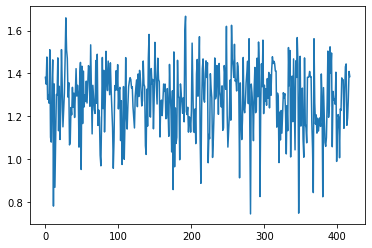

In [ ]:
plt.plot(np.log10((np.array(list(list(zs.values())[0].values())))))

10gs


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1054.0618104934692


(0.0, 50.0)

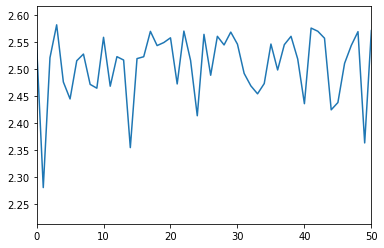

In [ ]:
def loop(data):
    """run model1
    
    later consider to put in the Hs after all, only for this first layerthen use updated pos"""
    #run model 1
    outs={}
    pdbs = data.pdbs
    #data=data.residues
    
    #Ds = {}
    all_zs={}
    for pdb in pdbs[:1]:
        zs={}
        print(pdb)
        out={}
        #d = data.residues[pdb]
        R, z = data.residues[pdb]["R"], data.atomic_numbers[pdb]

        for sample in z.keys():#len(feats)):
            feats=torch.tensor(z[sample])
            #print(feats)
            
            f=feats[feats != 1]
            coors=R[sample]
            pos = torch.tensor(list(coors.values())) #CHECKKKKK HERE FORRR MAJORRR POSSSSSIBLE ERRRROROROROR!! ACHTUNG)
            net = EGNN1(len(f),5)
            m=torch.tensor(3*[(np.array(torch.tensor(feats != 1)))])#.unsqueeze(0).shape
            c = pos[m.T].reshape(len(f),3,1).squeeze(2) #!!!!!!!!!!!!!!!!
            #print(f,c)
            #out=net(f.unsqueeze(0),c.unsqueeze(0))

    #x, _ = model(feats.unsqueeze(0), pos.unsqueeze(0)) #can turn off return po
            _ = net(f.unsqueeze(0),c.unsqueeze(0))
            out[sample] = _
            def dots(_):
                zs={}
                dots=[]
                for x in _[0]: #resi-species level resolution
                    z1=np.linalg.norm(np.sum(np.sum(np.gradient(np.gradient(x.detach().numpy())), axis=-1)[0],axis=-0))
                    #print(z1)
                    z2=np.linalg.norm(np.mean(np.mean(np.gradient(np.gradient(x.detach().numpy())), axis=-1)[0],axis=-0))
                    #print(z2)
                    
                    z3=(np.linalg.norm(np.mean(np.mean(np.gradient(np.gradient(x.detach().numpy())), axis=0)[0],axis=-0)))
                    #print(z3)
                    z=[z1,z2,z3]

                    #print(np.linalg.norm([z1,z2,z3])/np.mean(z))
                    #print(sample, "done")
                    return np.linalg.norm([z1,z2,z3]/np.mean(z))
                    #r=norms[species]
                    #o =np.vstack([[z],[r]])
                    #dots.append(np.dot(o[0,:]-np.mean(o[0,:]),o[1,:]-np.mean(o[1,:])))
                #return zs #dots
            #dots(_)
            zs[sample] = dots(_)
        outs[pdb] = out
        all_zs[pdb] = zs
    return outs, all_zs
    
    

all_outs,zs = loop(data)

#print(y.shape, pos.shape)

z=list(list(zs.values())[0].values())
print(sum(z))
plt.plot(list(list(zs.values())[0].values()))
plt.xlim(0,50)


In [ ]:
df[df.iloc[:, 0] == pdb].compute()

,idcode,chain,residue_name,residue_number,pk
402823,10gs,B,TYR,79,14.11070
439704,10gs,A,GLU,30,1.87639
476140,10gs,B,CYS,14,12.36700
500596,10gs,A,ASP,116,3.56210
518896,10gs,B,ASP,146,3.70626
...,...,...,...,...,...
625387,10gs,A,ASP,171,4.02678
649939,10gs,A,GLU,31,3.49100
649940,10gs,A,LYS,81,11.72780
662331,10gs,B,GLU,36,4.03344


In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 300)
df[df["idcode"] == "10gs"].compute()

,idcode,chain,residue_name,residue_number,pk
402823,10gs,B,TYR,79,14.110700
439704,10gs,A,GLU,30,1.876390
476140,10gs,B,CYS,14,12.367000
500596,10gs,A,ASP,116,3.562100
518896,10gs,B,ASP,146,3.706260
555782,10gs,A,LYS,140,10.347200
555783,10gs,B,CYS,101,10.448800
617240,10gs,A,CTR,209,2.243880
666009,10gs,B,TYR,198,11.196100
684414,10gs,B,ASP,82,2.103380


1054.0618104934692


(0.0, 50.0)

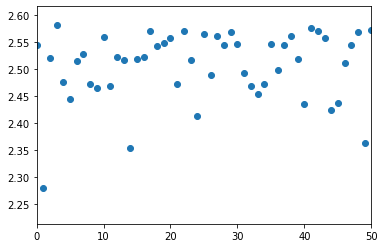

In [ ]:
z=list(list(zs.values())[0].values())
print(sum(z))
plt.plot(list(list(zs.values())[0].values()),"o")
plt.xlim(0,50)

/usr/lib64/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


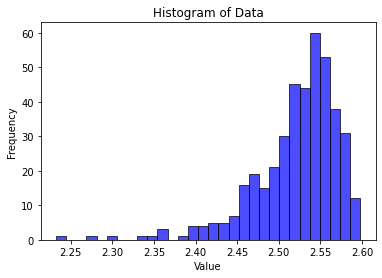

Shapiro-Wilk test statistic = 0.881, p-value = 0.000
Reject null hypothesis: data does not look normally distributed.


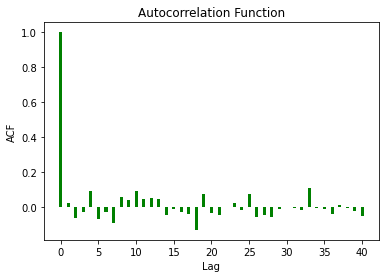

Runs test z-statistic = 0.686, p-value = 0.493
No strong evidence of non-randomness (fail to reject randomness).


In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.tsa.stattools import acf
from statsmodels.sandbox.stats.runs import runstest_1samp
#da=dot
# -----------------------------
# 1. Generate or load your data
# -----------------------------
# Example: Let's just create some data.
# Replace this with your actual data array.
#data = np.random.randn(200)  # random normal data for demonstration
#data=dots
for i in range(1):
    data=z
# -----------------------------------
# 2. Visualize the data distribution
# -----------------------------------
    plt.figure(figsize=(6,4))
    plt.hist(data, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Histogram of Data')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

    # -------------------------------------------------
    # 3. Test for normality (e.g., Shapiro-Wilk test)
    # -------------------------------------------------
    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk test statistic = {stat:.3f}, p-value = {p_value:.3f}")
    if p_value > 0.05:
        print("Fail to reject null hypothesis: data looks normally distributed.")
    else:
        print("Reject null hypothesis: data does not look normally distributed.")

    # -------------------------------------
    # 4. Check for autocorrelation
    # -------------------------------------
    acf_values = acf(data, fft=False)  # autocorrelation function
    lags = range(len(acf_values))

    plt.figure(figsize=(6,4))
    plt.bar(lags, acf_values, width=0.4, color='green')
    plt.title('Autocorrelation Function')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.show()

    # -------------------------------------
    # 5. Runs test for randomness
    # -------------------------------------
    # The runstest_1samp can be used to check if data is random above/below a cutoff
    # Default cutoff='median' means it checks how data points fall relative to median.
    z_stat, p_value_runs = runstest_1samp(data, cutoff='median')
    print(f"Runs test z-statistic = {z_stat:.3f}, p-value = {p_value_runs:.3f}")
    if p_value_runs > 0.05:
        print("No strong evidence of non-randomness (fail to reject randomness).")
    else:
        print("Data may not be random (reject randomness).")

z=list(list(zs.values())[0].values())
print(sum(z))
plt.plot(list(list(zs.values())[0].values()),"o")
plt.xlim(0,50)


go to 2 dims now bc redunandant

In [61]:
from sklearn.neighbors import NearestNeighbors
def get_spheres(all_coords, site, cutoff_radius):
    nbrs = NearestNeighbors(cutoff_radius).fit(all_coords) #prob np
    _, indices = nbrs.radius_neighbors(site) #list or np prob
    return all_coords[indices]
        
emb_layers=1

for i in range(2):
    for j in range(emb_layers):
        updated_coors={}
    ########################solute-solvent############################################label-independent############################################
        for resi in system:
            #feats, coors = EGNNEmbedder(dim=3, depth=depth)([species, coors], nloops=1) 
            updated_coors[resi] = coors
            reps[resi] = AttAgg(feats, coors)
    
    all_feats = ProteinAtt(reps) #[real_number_resis, 1]


    ##########################solution########################################need-labels##########################################################
    #hoods = [(sample, get_spheres(updated_coors.values(), site_indices[sample], cutoff_radius=4) for sample in labeled_samples)] #[labeled_resis, 1]


torch.Size([7])

I think it is a hard constraint that we must reinit a model each time, fresh for each structure.

so layer one becomes both an embedder and a way out of dimhell.